## Energy Consumption Forecast - An Approach with RNN
#### Junghanss, Juan Cruz 
#### Métodos Cuantitativos para Cs Sociales y Negocios | Prof: Sergio Pernice, PhD

In [1]:
# Importamos packages necesarios
import pandas as pd
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Ajustamos el formato del dataset
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [ ]:
"""Solo correr por primera vez"""
# Cargar datos desde el archivo Excel 
data = pd.read_excel('GEFCom2014-E.xlsx', engine='openpyxl', parse_dates=True)

# Crear variable Timestamp de Date y Hour
data['timestamp'] = data['Date'].add(pd.to_timedelta(data.Hour - 1, unit='h'))
data = data[['timestamp', 'load', 'T']]
data = data.rename(columns={'T':'temp'})

# Eliminar time period sin load data (sin datos de consumo)
data = data[data.timestamp >= '2012-01-01']

# Guardar a CSV
data.to_csv('energy.csv', index=False)

In [3]:
energy = pd.read_csv('energy.csv', parse_dates=['timestamp'])

# Reindexación del dataframe para que tenga un registro para cada punto del tiempo
# entre el minimo y máximo período de la serie. Esto ayuda a 
# identificar los períodos faltantes (missing) en los datos.

energy.index = energy['timestamp']
energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
energy = energy.drop('timestamp', axis=1)

In [4]:
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


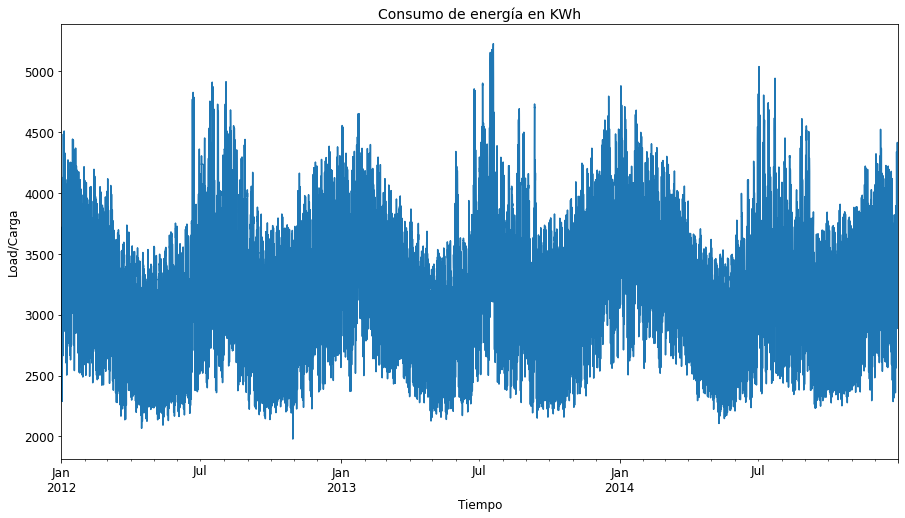

In [6]:
# Gráfico de todos los datos disponibles de energía (entre Enero 2012 a Dec 2014) - Es lo que usaremos
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12, legend=None)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Load/Carga', fontsize=12)
plt.title('Consumo de energía en KWh', fontsize=14)
plt.show()

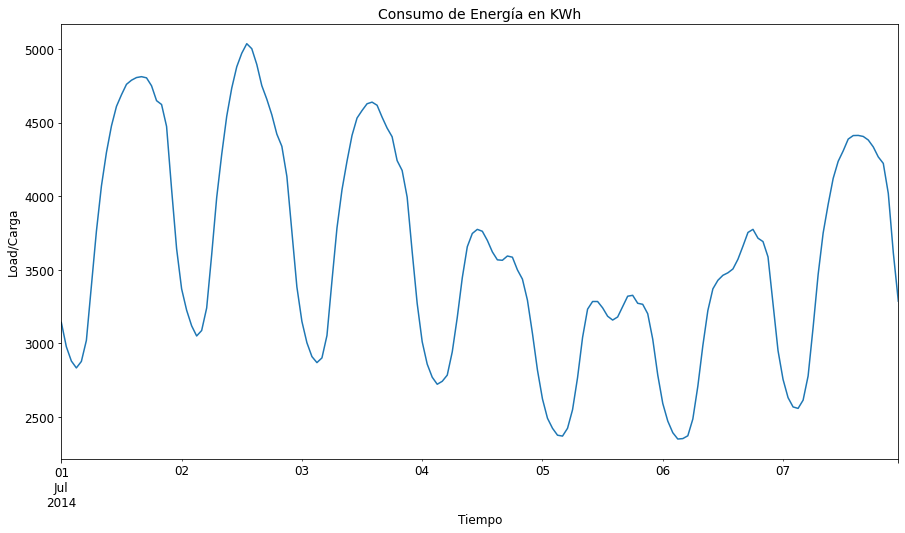

In [7]:
# Gráfico de primer semana de 2014 como ejemplo
energy['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12, legend=None)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Load/Carga', fontsize=12)
plt.title('Consumo de Energía en KWh', fontsize=14)
plt.show()

In [8]:
# El índice es DateTime
energy.index 

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq='H')

In [9]:
# Slicing para acceder a partes específicas. Se puede usar también el método .truncate() de Python
energy[:5].index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00'],
              dtype='datetime64[ns]', freq='H')

In [10]:
# Podemos pasar también la fecha como string para una búsqueda más específica
energy['2013-6-01']
# energy['2013-6-01':'2013-15-01']

<ipython-input-10-d778261dc7ec>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  energy['2013-6-01']


,load,temp
2013-06-01 00:00:00,"2,968.00",70.67
2013-06-01 01:00:00,"2,801.00",69.00
2013-06-01 02:00:00,"2,702.00",67.33
2013-06-01 03:00:00,"2,644.00",66.67
2013-06-01 04:00:00,"2,635.00",64.67
2013-06-01 05:00:00,"2,659.00",63.67
2013-06-01 06:00:00,"2,880.00",65.33
2013-06-01 07:00:00,"3,218.00",70.33
2013-06-01 08:00:00,"3,546.00",75.67
2013-06-01 09:00:00,"3,797.00",80.00


### One step univariate model

In [11]:
import warnings
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

warnings.filterwarnings("ignore")

In [12]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

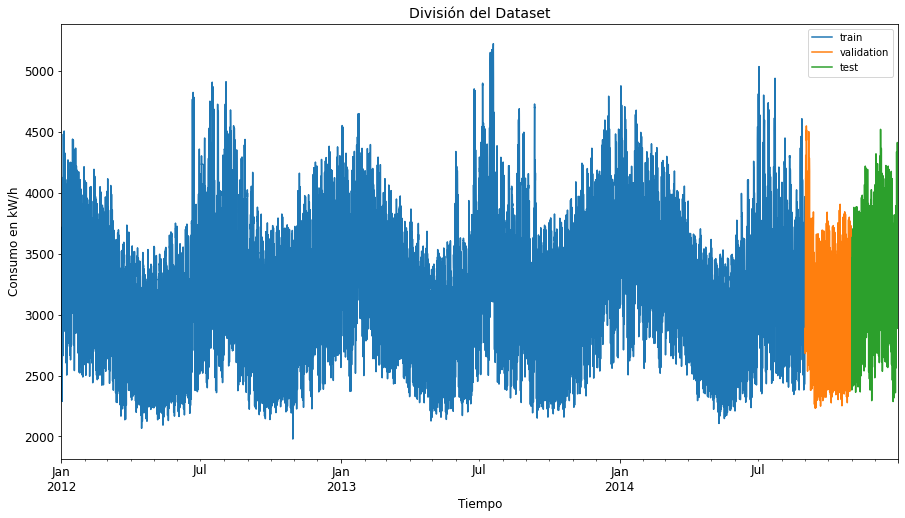

In [13]:
# plt.style.use('seaborn')
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Consumo en kW/h', fontsize=12)
plt.title('División del Dataset',fontsize=14)
plt.show()

### Data preparation
Para este ejemplo setearemos T=6, lo que significa que cada input sample es un vector de las 6 horas previas de consumo de energía. Esta decisión es arbitraria y la podemos cambiar si experimentamos.

HORIZON=1 Especificamos nuestro horizonte de pronostico en t+1


La preparación de los datos (para cada dataset: train / valid / test) consta de los siguientes pasos:

1. Filtramos el dataset original trayendo solamente los datos en el rango correcto que corresponda al set indicado

2. Escalamos la serie de tiempo tal que los valores caigan en el intervalo (0,1) así evitamos se filtren otros datos

3. Armamos un dataframe que contenga todos los input samples.

4. Eliminamos todos los missing values

5. Transformamos el dataframe en un array de numpy con shape (samples, time steps, features) para input en Keras

In [14]:
T = 6         # Hiperparámetro tamaño de la secuencia del input
HORIZON = 1   # Hiperparámetro horizonte (t+1)

In [15]:
# 1. Traemos los datos para el entrenamiento del rango de fechas valido
train = energy.copy()[energy.index < valid_start_dt][['load']]

# 2. Escalamos los datos para valores entre (0, 1). 
#   Esta calibración se hace solamente en el training set. 
#   Es para prevenir se filtre información del validation o test sets adentro del entrenamiento! 

scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

# 3. Cambiamos el dataframe para crear los samples de entrada (input).
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols

# 4. Eliminamos (dropeamos) cualquier sample con missing value
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


Ahora, convertimos el target e input features en arrays de numpy. X tiene que estar en el shape (samples, time steps, features). Acá tenemos 23370 samples, 6 time steps (de T) y 1 feature solo (load).

In [16]:
# 5.Transformamos el Dataframe en un vector (array) de Numpy
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [17]:
# Tenemos que cambiar la dimension que se compone de (23370, 6, 1)
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [18]:
print(X_train)

[[[0.22]
  [0.18]
  [0.14]
  [0.13]
  [0.13]
  [0.15]]

 [[0.18]
  [0.14]
  [0.13]
  [0.13]
  [0.15]
  [0.18]]

 [[0.14]
  [0.13]
  [0.13]
  [0.15]
  [0.18]
  [0.23]]

 ...

 [[0.57]
  [0.58]
  [0.6 ]
  [0.61]
  [0.61]
  [0.58]]

 [[0.58]
  [0.6 ]
  [0.61]
  [0.61]
  [0.58]
  [0.51]]

 [[0.6 ]
  [0.61]
  [0.61]
  [0.58]
  [0.51]
  [0.43]]]


Ahora tenemos un vector para la variable explicada del shape:

In [19]:
y_train.shape

(23370,)

La variable explicada se ve, para los primeros 3 samples, como:

In [20]:
y_train[:3]

array([0.18, 0.23, 0.29])

El tensor para el input features tiene la dimension: 

In [21]:
X_train.shape

(23370, 6, 1)

In [22]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


### Data preparation - validation set
Repetimos el proceso similar para el validation set. 

In [23]:
# 1. Tomamos los datos de validación en el rango de tiempo correcto
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]

# 2. Escalas la serie usando el trasnformador ajustado en el set de entrenamiento:
valid['load'] = scaler.transform(valid)

# 3. Cambiamos el dataframe para crear los samples de entrada (input).
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
    
# 4. Eliminamos (dropeamos) cualquier sample con missing value
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.28,0.24,0.61,0.58,0.51,0.43,0.34,0.28
2014-09-01 01:00:00,0.24,0.22,0.58,0.51,0.43,0.34,0.28,0.24
2014-09-01 02:00:00,0.22,0.22,0.51,0.43,0.34,0.28,0.24,0.22


In [24]:
# 5. Transformamos el dataframe en un vector
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [25]:
y_valid.shape

(1463,)

In [26]:
y_valid[:3]

array([0.24, 0.22, 0.22])

In [27]:
X_valid.shape

(1463, 6, 1)

### Implement the RNN


In [28]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [29]:
LATENT_DIM = 5 # Hiperparametro de nro unidades en la capa RNN
BATCH_SIZE = 32 # Hiperparametro: nro de samples por mini-batch 
EPOCHS = 10 # Maximo nro de veces que el algo de entrenamiento iterará todos los samples

In [30]:
model = Sequential()   # Definimos (con Keras) al modelo como uno Secuencial 
model.add(GRU(LATENT_DIM, input_shape=(T, 1))) # Agregamos una GRU de 5 unidades (LATENT_DIM)
model.add(Dense(HORIZON)) # Dense Layer de la NN de 1 unidad

Usaremos Mean Squared Error como la función de pérdida (objetivo a minimizar). La documentación de Keras recomienda usar el RMSProp para Redes Neuronales Recurrentes:   https://faroit.com/keras-docs/2.0.2/optimizers/

In [31]:
model.compile(optimizer='RMSprop', loss='mse')  # Especificamos el algoritmo de aprendizaje y la funcion objetivo

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


Especificamos el criterio para early stopping (detener el aprendizaje). Monitorearemos la pérdida de validación (en este caso, del Mean Squared Error) en el set de validación luego de cada training epoch. Si la pérdida de validación no mejora en _min_delta_ luego de _patience_ epochs, detendremos el training.

In [33]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5) 
# Esta clase (EarlyStopping) es para detener el training cuando una métrica deja de cambiar
# Parámetros: monitoreamos el valor de la loss function, min_delta es el delta mínimo a considerar como mejora de la f.objetivo
# y patience es el número de epochs sin cambio alguno luego de los cuales se detiene el training

In [34]:
# Corremos el modelo y comienza a entrenarse. Ver cómo disminuye el "val_loss". En la próxima celda lo ploteamos
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/10
731/731 [==============================] - 31s 7ms/step - loss: 0.0511 - val_loss: 0.0018
Epoch 2/10
731/731 [==============================] - 4s 5ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 3/10
731/731 [==============================] - 6s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/10
731/731 [==============================] - 7s 9ms/step - loss: 8.3488e-04 - val_loss: 7.4674e-04
Epoch 5/10
731/731 [==============================] - 4s 5ms/step - loss: 6.8352e-04 - val_loss: 5.7788e-04
Epoch 6/10
731/731 [==============================] - 3s 5ms/step - loss: 5.8420e-04 - val_loss: 5.1545e-04
Epoch 7/10
731/731 [==============================] - 4s 5ms/step - loss: 5.7446e-04 - val_loss: 5.9434e-04
Epoch 8/10
731/731 [==============================] - 4s 6ms/step - loss: 5.6909e-04 - val_loss: 6.1180e-04
Epoch 9/10
731/731 [==============================] - 4s 5ms/step - loss: 5.7335e-04 - val_loss: 6.4949e-04
Epoch 10/10
731/731 [==============================

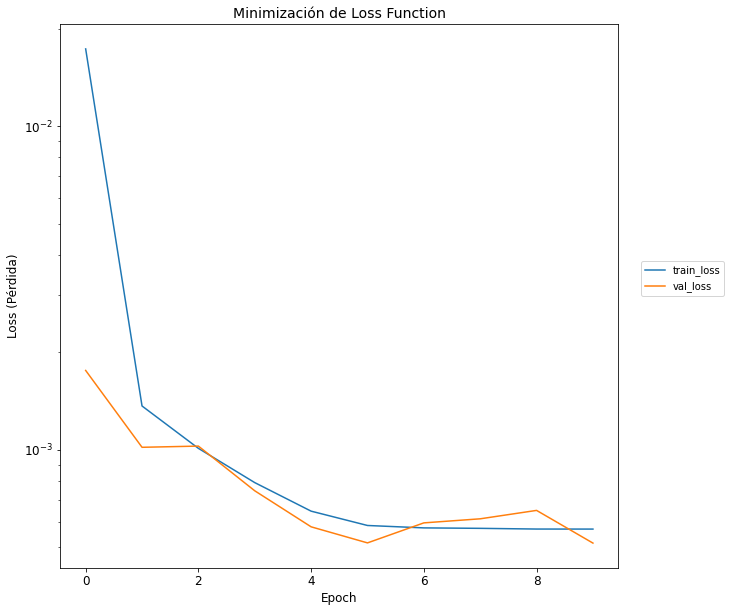

In [35]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Pérdida)', fontsize=12)
plt.title('Minimización de Loss Function', fontsize=14)
plt.legend(loc=(1.04,0.5))
plt.show()

### Evaluate the model


Data preperation - test set

In [36]:
# Mismo proceso que los otros sets
# 1. Tomamos los datos de testeo del rango correcto
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]

# 2. Escalamos los datos, igual que antes
test['load'] = scaler.transform(test)

# 3. Modificamos el dataframe para crear los samples de input
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# 4. Descartamos los samples con missing values
test_shifted = test_shifted.dropna(how='any')

# 5. Transformamos el dataframe en un vector
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [37]:
y_test.shape

(1458,)

In [38]:
X_test.shape

(1458, 6, 1)

Hacemos las predicciones en el test set:

In [39]:
# Predicción:
predictions = model.predict(X_test)  # Usamos el método predict() y le pasamos el único argumento obligatorio: el input vector
predictions

array([[0.21],
       [0.29],
       [0.38],
       ...,
       [0.52],
       [0.46],
       [0.42]], dtype=float32)

In [40]:
# Evaluación:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,661.91","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,930.38","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,199.11","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,336.47","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,464.77","3,436.00"


Computamos el MAPE sobre TODAS las predicciones

In [41]:
# Armamos nuestra propia función para computar el MAPE
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [42]:
mape(eval_df['prediction'], eval_df['actual'])

0.016104323551220903

Gráficamos las predicciones vs los valores realizados para la primer semana del test set. Luego lo hacemos, para contrastar, en 3 semanas y 2 días.


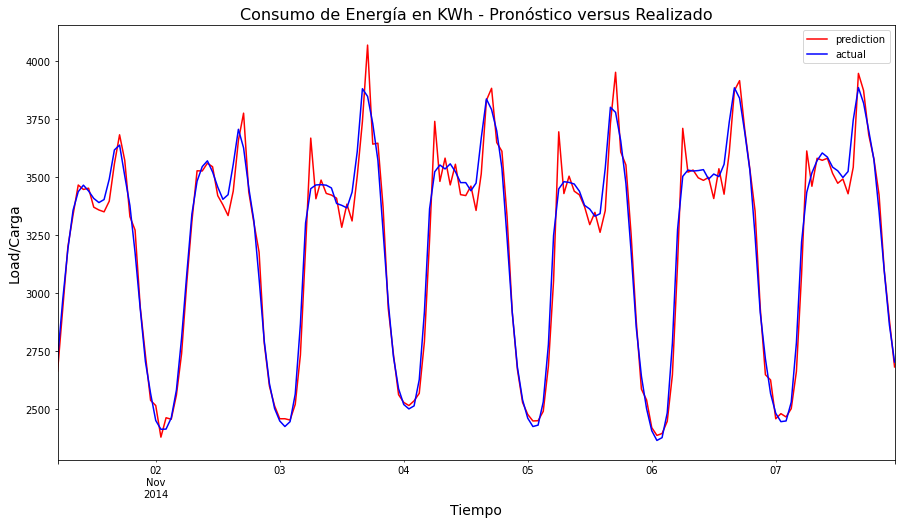

In [43]:
# Grafico de 1 semana
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Load/Carga', fontsize=14)
plt.title('Consumo de Energía en KWh - Pronóstico versus Realizado', fontsize=16)
plt.show()

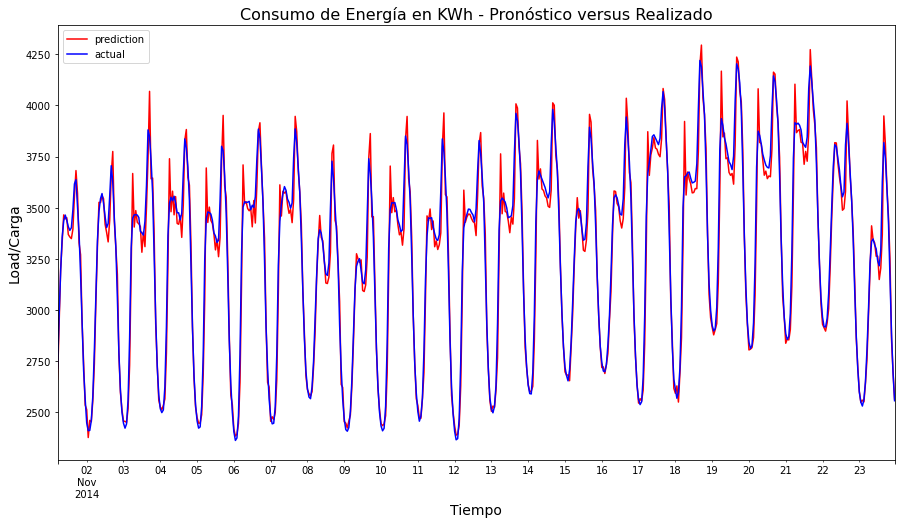

In [45]:
# Grafico de 3 semanas
eval_df[eval_df.timestamp<'2014-11-24'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Load/Carga', fontsize=14)
plt.title('Consumo de Energía en KWh - Pronóstico versus Realizado', fontsize=16)
plt.show()

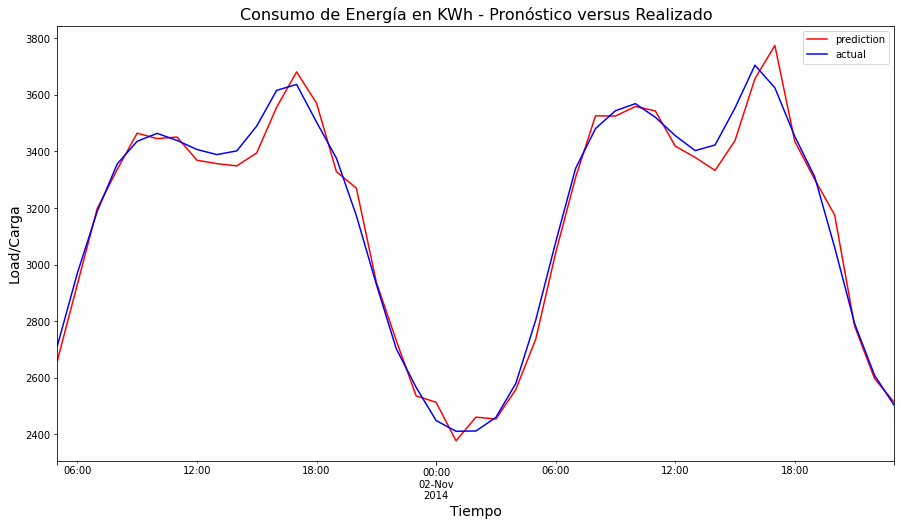

In [48]:
# Grafico de 2 días
eval_df[eval_df.timestamp<'2014-11-03'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Load/Carga', fontsize=14)
plt.title('Consumo de Energía en KWh - Pronóstico versus Realizado', fontsize=16)
plt.show()